# strategy

In [ ]:
اگر مقدار پول نان بود یعنی اون اندیکاتور سیگنال نداشته که بخواد  مقداری برگردونه

# run backtest for one strategy

In [ ]:
%reset -f
import datetime
import os.path
import sys
import pandas as pd
import talib
import numpy as np
import talib as ta
from ta_calculat import runmain
import threading
import pickle
import time
import gc

print(time.ctime())
class backtest():
    def __init__(self,datasignal=None,leverage=1,BUY=True,SELL=True,total_size=False,
                 trigger=None,Commission=None,sl=None,tp=None,value=None,stoptraill=None,size=1):
        self.order=[('index','type position')]
        self.leverage=leverage
        self.leveragevalue=value*self.leverage-value
        self.datasignal=datasignal
        #cash is all money without open orders
        self.controlorder=['sl_tp','stoptraill']
        self.trigger=trigger    # sl_tp  or  stoptraill
        self.size=size
        self.total_size=total_size
        self.data=None
        self.gross=None
        self.profit=[('index','traillist','size','start-price','stopprice','open','high','low','percent profit (%)','gain','type position')]
        self.lose=[('index','traillist','size','start-price','stopprice','open','high','low','percent lose (%)','lose','type position')]
        self.cash=value*self.leverage
        self.actionprice=None
        self.value=value*self.leverage
        self.sl=sl
        self.tp=tp
        self.stoptraill=stoptraill
        self.pricestoptraill=None
        self.Commission=Commission
        self.typeposition=None
        self.buyorsell=pd.DataFrame()
        self.BUY=BUY
        self.SELL=SELL
    def sizer(self,n):
        try:
            if self.total_size==True:
                sizer=self.cash/self.data.loc[n,'open']
            else:
                sizer=self.size
        except Exception as error:
            print(error)
            print('***',n,'****')
        return sizer

    def getdata(self):
        global timeframe
        df = pd.read_pickle("data_pairs_kucoin_future_%s.pkl" % (timeframe)).loc[0,'pair']
        df['date'] = df['date'].astype(str) +' '+ df['time'].astype(str)
        df['date']= pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M:%S')
        df.set_index('date', inplace=True)
        df.drop('time', axis=1,inplace=True)
        df.reset_index(drop=True, inplace=True)
        return df

    def buy(self,j):
        starti=j
#         print('\n',j,'buy','\n')
        self.typeposition='buy'
        self.order.append((j,self.typeposition))
        self.actionprice=self.data.loc[j,'open']
        self.pricestoptraill=self.actionprice
        self.cash=self.value-self.actionprice*self.size
        traillist=[]
        b=0
        while b==0:

            if self.trigger==self.controlorder[0]:

                if self.data.loc[i,'low']<=(1-self.sl)*self.actionprice\
                or self.data.loc[i,'high']>=(1+self.tp)*self.actionprice or j>=len(self.data)-3:
                    self.gross=((self.data.loc[i,'close']-self.actionprice)/self.actionprice)*100

                    comis=self.data.loc[i,'close']*self.size*self.Commission
                    gain=(self.data.loc[i,'close']*self.size-self.actionprice*self.size)-comis
                    
                    

                    self.value=self.value+gain

                    self.cash=self.cash+self.data.loc[i,'close']*self.size-comis
                    

                    if self.gross>=0:
                        self.profit.append(('start:%s - end:%s' % (starti,i),self.data.loc[starti,'open'],self.data.loc[i,'high'],
                                            self.data.loc[i,'low'],(1-self.stoptraill)*self.data.loc[i,'low'],
                                            (self.stoptraill+1)*self.data.loc[i,'high'],
                                            float("{:.2f}".format(self.gross)),
                                            float("{:.2f}".format(gain)),self.typeposition))

                    if self.gross<0:
                        self.lose.append(('start:%s - end:%s' % (starti,i),self.data.loc[starti,'open'],self.data.loc[i,'high'],
                                            self.data.loc[i,'low'],(1-self.stoptraill)*self.data.loc[i,'low'],
                                            (self.stoptraill+1)*self.data.loc[i,'high'],
                                            float("{:.2f}".format(self.gross)),
                                            float("{:.2f}".format(gain)),self.typeposition))
                    #profit
                    break

            elif self.trigger==self.controlorder[1]:
                
                if self.data.loc[j,'low'] - self.Commission*self.data.loc[j,'low']<=\
                (1-(self.sl/self.leverage))*self.pricestoptraill\
                or self.data.loc[j,'close'] - self.Commission*self.data.loc[j,'close']<=\
                (1-(self.sl/self.leverage))*self.pricestoptraill\
                or j>=len(self.data)-3:
                    
                    if  self.data.loc[j,'low'] - self.Commission*self.data.loc[j,'low']<=\
                    (1-(self.sl/self.leverage))*self.pricestoptraill:
                        stopprice=self.data.loc[j,'low']
                    elif self.data.loc[j,'close'] - self.Commission*self.data.loc[j,'close']<=\
                    (1-(self.sl/self.leverage))*self.pricestoptraill:
                        stopprice=self.data.loc[j,'close']
                    else:
                        stopprice=self.data.loc[j,'close']
                    #-----------------------------------------------------------    
                    self.gross=((stopprice-self.actionprice)/self.actionprice)*100

                    comis=stopprice*self.size*self.Commission
                    gain=(stopprice*self.size-self.actionprice*self.size)-comis

                    self.value=self.value+gain

                    self.cash=self.cash+stopprice*self.size-comis
                    if self.gross>=0:
                        self.profit.append(('start:%s - end:%s' % (starti,j),traillist,
                                            self.size,
                                            self.actionprice,stopprice,
                                            self.data.loc[j,'open'],self.data.loc[j,'high'],
                                            self.data.loc[j,'low'],
                                            float("{:.2f}".format(self.gross)),
                                            float("{:.2f}".format(gain)),self.typeposition))

                    if self.gross<0:
                        self.lose.append(('start:%s - end:%s' % (starti,j),traillist,
                                          self.size,
                                          self.actionprice,stopprice,
                                          self.data.loc[j,'open'],self.data.loc[j,'high'],
                                            self.data.loc[j,'low'],
                                            float("{:.2f}".format(self.gross)),
                                            float("{:.2f}".format(gain)),self.typeposition))
                    #profit
                    b=0
                elif (self.data.loc[j,'high']-self.data.loc[j,'high']*self.Commission)/self.pricestoptraill>=\
                (1+(self.stoptraill/self.leverage))\
                or (self.data.loc[j,'close']-self.data.loc[j,'close']*self.Commission)/self.pricestoptraill>=\
                (1+(self.stoptraill/self.leverage)):
                    
                    if  (self.data.loc[j,'high']-self.data.loc[j,'high']*self.Commission)/self.pricestoptraill>=\
                (1+(self.stoptraill/self.leverage)):
                        self.pricestoptraill=self.data.loc[j,'high']
                    elif (self.data.loc[j,'close']-self.data.loc[j,'close']*self.Commission)/self.pricestoptraill>=\
                (1+(self.stoptraill/self.leverage)):
                        self.pricestoptraill=self.data.loc[j,'close']
                    
                    traillist.append(self.pricestoptraill)

            j+=1

        return j

    def sell(self,j):
        starti=j
#         print('\n',j,'sell','\n')
        self.typeposition='sell'
        self.order.append((j,self.typeposition))
        self.actionprice=self.data.loc[j,'open']
        self.pricestoptraill=self.actionprice
        self.cash=self.value-self.actionprice*self.size
        traillist=[]
        b=1

        while b==1:

            if self.trigger==self.controlorder[0]:
                if self.data.loc[j,'high']>=(1+self.sl)*self.actionprice \
                or self.data.loc[j,'low']<=(1-self.tp)*self.actionprice or j>=len(self.data)-3:
                    self.gross=((self.actionprice-self.data.loc[j,'close'])/self.actionprice)*100

                    comis=((self.actionprice*self.size-self.data.loc[j,'close']*self.size)+\
                    self.actionprice*self.size)*self.Commission
                    
                    self.cash=self.cash+((self.actionprice*self.size-self.data.loc[j,'close']*self.size)+\
                    self.actionprice*self.size)-comis

                    gain=(self.actionprice*self.size-self.data.loc[j,'close']*self.size)-comis

                    self.value=self.value+gain

                    if self.gross>=0:
                        self.profit.append(('start:%s - end:%s' % (starti,j),self.data.loc[starti,'open'],self.data.loc[j,'high'],
                                            self.data.loc[j,'low'],(1-self.stoptraill)*self.data.loc[j,'low'],
                                            (self.stoptraill+1)*self.data.loc[j,'high'],
                                            float("{:.2f}".format(self.gross)),
                                            float("{:.2f}".format(gain)),self.typeposition))

                    if self.gross<0:
                        self.lose.append(('start:%s - end:%s' % (starti,j),self.data.loc[starti,'open'],self.data.loc[j,'high'],
                                            self.data.loc[j,'low'],(1-self.stoptraill)*self.data.loc[j,'low'],
                                            (self.stoptraill+1)*self.data.loc[j,'high'],
                                            float("{:.2f}".format(self.gross)),
                                            float("{:.2f}".format(gain)),self.typeposition))
                    break

            elif self.trigger==self.controlorder[1]:

                if (self.data.loc[j,'high'] + self.Commission*self.data.loc[j,'high'])>=\
                (1+(self.sl/self.leverage))*self.pricestoptraill \
                or (self.data.loc[j,'close'] + self.Commission*self.data.loc[j,'close'])>=\
                (1+(self.sl/self.leverage))*self.pricestoptraill\
                or j>=len(self.data)-3:
                    
                    if  self.data.loc[j,'high'] + self.Commission*self.data.loc[j,'high']>=\
                    (1+(self.sl/self.leverage))*self.pricestoptraill:
                        stopprice=self.data.loc[j,'high']
                    elif self.data.loc[j,'close'] + self.Commission*self.data.loc[j,'close']>=\
                    (1+(self.sl/self.leverage))*self.pricestoptraill:
                        stopprice=self.data.loc[j,'close']
                    else:
                        stopprice=self.data.loc[j,'close']
                    #-----------------------------------------------------------     
                    self.gross=((self.actionprice-stopprice)/self.actionprice)*100
                    comis=((self.actionprice*self.size-stopprice*self.size)+\
                    self.actionprice*self.size)*self.Commission
                    
                    self.cash=self.cash+((self.actionprice*self.size-stopprice*self.size)+\
                    self.actionprice*self.size)-comis

                    gain=(self.actionprice*self.size-stopprice*self.size)-comis

                    self.value=self.value+gain

                    if self.gross>=0:
                        self.profit.append(('start:%s - end:%s' % (starti,j),traillist,
                                            self.size,
                                            self.actionprice,stopprice,
                                          self.data.loc[j,'open'],self.data.loc[j,'high'],
                                            self.data.loc[j,'low'],
                                            float("{:.2f}".format(self.gross)),
                                            float("{:.2f}".format(gain)),self.typeposition))

                    if self.gross<0:
                        self.lose.append(('start:%s - end:%s' % (starti,j),traillist,
                                          self.size,
                                          self.actionprice,stopprice,
                                          self.data.loc[j,'open'],self.data.loc[j,'high'],
                                            self.data.loc[j,'low'],
                                            float("{:.2f}".format(self.gross)),
                                            float("{:.2f}".format(gain)),self.typeposition))
                    b=0
                elif (self.data.loc[j,'low']+self.data.loc[j,'low']*self.Commission)/self.pricestoptraill<=\
                (1-(self.stoptraill/self.leverage))\
                or (self.data.loc[j,'close']+self.data.loc[j,'close']*self.Commission)/self.pricestoptraill<=\
                (1-(self.stoptraill/self.leverage)):
                    
                    if  (self.data.loc[j,'low']+self.data.loc[j,'low']*self.Commission)/self.pricestoptraill<=\
                (1-(self.stoptraill/self.leverage)):
                        self.pricestoptraill=self.data.loc[j,'low']
                    elif (self.data.loc[j,'close']+self.data.loc[j,'close']*self.Commission)/self.pricestoptraill<=\
                (1-(self.stoptraill/self.leverage)):
                        self.pricestoptraill=self.data.loc[j,'close']
                    
                    traillist.append(self.pricestoptraill)

            j+=1

        return j

    def run(self):
        ilist=[]

        self.data=self.getdata()
        c=0
        try:
            while c< len(self.data):

                ilist.append(c)
                if c>= len(self.data)-5:
                    break

                if self.BUY==True:
                    if self.datasignal.loc[c,'sellorbuy']==1: # 1==buy
                        self.size=self.sizer(c+1)
                        if int(self.data.loc[c+1,'open']*self.size)<=int(self.cash):
                            c=self.buy(c)
                            c-=1
                        else:

                            print('********************** no enough cash for buy **********************')
                            print(c,self.size,self.data.loc[c+1,'open']*self.size,'<=',self.cash)
                            continue
                if self.SELL==True:

                    if self.datasignal.loc[c,'sellorbuy']==0: # 0==sell
                        self.size=self.sizer(c+1)
                        if int(self.data.loc[c+1,'open']*self.size)<=int(self.cash):
                            c=self.sell(c)
                            c-=1
                        else:
                            print('**********************no enough cash for sell **********************')
                            print(c,self.size,self.data.loc[c+1,'open']*self.size,'<=',self.cash)
                            continue
                c+=1
        except Exception as error:
            print('#',c,'#')
            print(error)



        self.order=pd.DataFrame(self.order)
        self.order.columns = self.order.iloc[0] #set the header row as the df header
        self.order = self.order[1:] #take the data less the header row
        self.profit=pd.DataFrame(self.profit)
        self.profit.columns = self.profit.iloc[0]
        self.profit = self.profit[1:]
        self.lose=pd.DataFrame(self.lose)
        self.lose.columns = self.lose.iloc[0]
        self.lose = self.lose[1:]
        
        if self.leverage>1:
            self.value=self.value-self.leveragevalue
  
        return self.order ,self.profit ,self.lose ,self.value,ilist

    
    
def startbacktest(s,l,st,inde,column):
    global alldata
    global queue
    result_order=pd.DataFrame(index=inde,columns=column)
    result_profit=pd.DataFrame(index=inde,columns=column)
    result_lose=pd.DataFrame(index=inde,columns=column)
    result_value=pd.DataFrame(index=inde,columns=column)
    list_i=pd.DataFrame(index=inde,columns=column)
    for j in sellorbuy.columns:
        for i in sellorbuy.index:
            if type(sellorbuy.loc[i,j])==int:
                continue
            datasignal=sellorbuy.loc[i,j].copy()
            bt=backtest(datasignal=datasignal,total_size=True,value=100,trigger='stoptraill',
                        Commission=0.002,stoptraill=st,sl=s,leverage=l)
            order,profit,lose,value,ilist=bt.run()
            result_order.at[i,j]=order
            result_profit.at[i,j]=profit
            result_lose.at[i,j]=lose
            result_value.at[i,j]=value
            list_i.at[i,j]=ilist

    ui=1
    while ui==1:
        if queue==0:
            queue=1
            break
        time.sleep(1)
    alldata.at['result_order','%s-%s-%s' % (s,l,st)]=result_order
    alldata.at['result_profit','%s-%s-%s' % (s,l,st)]=result_profit
    alldata.at['result_lose','%s-%s-%s' % (s,l,st)]=result_lose
    alldata.at['result_value','%s-%s-%s' % (s,l,st)]=result_value
    alldata.at['listi','%s-%s-%s' % (s,l,st)]=list_i
    queue=0
    return
queue=0

sl=list(np.around(np.array(np.arange(0.01, 0.06, 0.01).tolist()),2))
stoptraill=list(np.around(np.array(np.arange(0.01, 0.25, 0.01).tolist()),2))
leverage=list(np.around(np.array(np.arange(1, 16, 1).tolist()),2))

timeframe='1m'
limit=1500
# sellorbuy=runmain(timeframe,limit)
# sellorbuy.to_pickle("sellorbuy.pkl")
sellorbuy = pd.read_pickle("sellorbuy.pkl")
inde=sellorbuy.index
column=sellorbuy.columns
#-----------------------------------------------------
colmalldata=[]
for s in sl:
    for l in leverage:
        for st in stoptraill:
            colmalldata.append('%s-%s-%s' % (s,l,st))
alldata=pd.DataFrame(index=['result_order','result_profit','result_lose','result_value','listi'],columns=colmalldata)

for s in sl:
    print('\n',s,end='-\n')
    for l in leverage:
        print('\n',l,end='-\n')
        threads=[]
        for st in stoptraill:
            print(st,end='-')
#             startbacktest(s,l,st,inde,column,)

            thread=threading.Thread(target=startbacktest,args=(s,l,st,inde,column,))
            thread.start()
            threads.append(thread)
        for thread in threads:
            thread.join()
alldata.to_pickle("alldata.pkl")
#--------------------------------------------
#0.01-3-0.15
print('\n',time.ctime())
#-----------------------------------------------------
# result_order=pd.DataFrame(index=inde,columns=column)
# result_profit=pd.DataFrame(index=inde,columns=column)
# result_lose=pd.DataFrame(index=inde,columns=column)
# result_value=pd.DataFrame(index=inde,columns=column)
# list_i=pd.DataFrame(index=inde,columns=column)
# for j in sellorbuy.columns:
#     for i in sellorbuy.index:
#         if type(sellorbuy.loc[i,j])==int:
#             continue
#         print('\n',i , j,'------------------------------------------------------------','\n' )
#         datasignal=sellorbuy.loc[i,j].copy()
#         bt=backtest(datasignal=datasignal,total_size=True,value=100,trigger='stoptraill',
#                     Commission=0.002,stoptraill=0.15,sl=0.01,leverage=3)
#         order,profit,lose,value,ilist=bt.run()
#         result_order.at[i,j]=order
#         result_profit.at[i,j]=profit
#         result_lose.at[i,j]=lose
#         result_value.at[i,j]=value
#         list_i.at[i,j]=ilist


In [3]:
# from ta_calculat import runmain
# sellorbuy=runmain('5m',540)
# sellorbuy.loc['bbands','signal0'].iloc[-30::]
rond=2
import pandas as pd
import numpy as np
sellorbuy=pd.read_pickle("sellorbuy.pkl")
sellorbuy.loc['bbands','signal0'].iloc[-1]=0
sellorbuy.loc['bbands','signal0'].iloc[-1]
sellorbuy.to_pickle( "sellorbuy.pkl" )

In [14]:
len(str(0.3455).split(".")[1])
round(0.34552,4)

0.3455

In [5]:
import pandas as pd
import numpy as np
rond=4
detail_accuonts=pd.read_pickle("detail_accuonts.pkl")
detail_accuonts

,user1
availableBalance,11.95185
calculated_size,7
type_ballance,"[XBT, USDT, XRP, ETH, DOT]"
api_key,62e3e694054f1e0001127930
api_passphrase,92237302790
stop_trail,0.3331
api_secret,a75605e8-aea9-4eb3-bc2a-d90c0c063a3f
id,62e41bfb05975d0001f4335b
leverage,2
side,sell


In [29]:

address='F:/ارز دیجیتال-فارکس/Python Scripts/ccxt/module/bot/آنالیز دیتا'
detail={'andicator':'','signal':'','st':'','leverage':'','sl':''}
filltred_strategy = pd.read_pickle('%s/filltred_strategy.pkl'% (address))
order_details={}
j=0
for i in filltred_strategy.index:
    if list(filltred_strategy.index).index(i)==0:
        print('1',end='-')
        detail['andicator']=i.split('*')[0]
        detail['signal']=i.split('*')[1]
        detail['st']=float(i.split('*')[2].split('-')[2])
        detail['leverage']=float(i.split('*')[2].split('-')[1])
        detail['sl']=float(i.split('*')[2].split('-')[0])
        order_details[i.split('*')[0]]=detail.copy()
        print(detail ,'\n',order_details)
    j+=1
    if i.split('*')[0]!=detail['andicator']:
        print('1',end='-')
        detail['andicator']=i.split('*')[0]
        detail['signal']=i.split('*')[1]
        detail['st']=float(i.split('*')[2].split('-')[2])
        detail['leverage']=int(i.split('*')[2].split('-')[1])
        detail['sl']=float(i.split('*')[2].split('-')[0])
        order_details[i.split('*')[0]]=detail.copy()
        print(detail ,'\n',order_details)
        break

1-{'andicator': 'wma', 'signal': 'signal3', 'st': 0.11, 'leverage': 2.0, 'sl': 0.04} 
 {'wma': {'andicator': 'wma', 'signal': 'signal3', 'st': 0.11, 'leverage': 2.0, 'sl': 0.04}}
1-{'andicator': 'macd', 'signal': 'signal0', 'st': 0.16, 'leverage': 2, 'sl': 0.05} 
 {'wma': {'andicator': 'wma', 'signal': 'signal3', 'st': 0.11, 'leverage': 2.0, 'sl': 0.04}, 'macd': {'andicator': 'macd', 'signal': 'signal0', 'st': 0.16, 'leverage': 2, 'sl': 0.05}}


In [19]:
t=list(filltred_strategy.index)
t.index('wma*signal3*0.04-2-0.11')
# t

0

In [22]:
display(order_details)
display(filltred_strategy)
filltred_strategy.index
filltred_strategy.index[0].split('*')[1]

{'wma': {'andicator': 'macd',
  'signal': 'signal0',
  'st': 0.16,
  'leverage': 2,
  'sl': 0.05},
 'macd': {'andicator': 'macd',
  'signal': 'signal0',
  'st': 0.16,
  'leverage': 2,
  'sl': 0.05}}

,number_positive,sum_value,all_trade,devition,dif_Np_Nl,avg,list_positive_value
wma*signal3*0.04-2-0.11,4.0,4.446201,5.0,1.598817,3.0,2.119434,"[3.3928741092636585, 0.21829293817236817, 3.98..."
wma*signal3*0.04-2-0.19,4.0,4.446201,5.0,1.598817,3.0,2.119434,"[3.3928741092636585, 0.21829293817236817, 3.98..."
wma*signal3*0.04-2-0.17,4.0,4.446201,5.0,1.598817,3.0,2.119434,"[3.3928741092636585, 0.21829293817236817, 3.98..."
wma*signal3*0.04-2-0.16,4.0,4.446201,5.0,1.598817,3.0,2.119434,"[3.3928741092636585, 0.21829293817236817, 3.98..."
wma*signal3*0.04-2-0.2,4.0,4.446201,5.0,1.598817,3.0,2.119434,"[3.3928741092636585, 0.21829293817236817, 3.98..."
...,...,...,...,...,...,...,...
macd*signal1*0.05-1-0.04,1.0,2.768413,5.0,0.000000,-1.0,5.413035,[5.413034573160743]
macd*signal1*0.05-1-0.03,1.0,2.768413,5.0,0.000000,-1.0,5.413035,[5.413034573160743]
macd*signal1*0.05-1-0.19,1.0,2.768413,5.0,0.000000,-1.0,5.413035,[5.413034573160743]
macd*signal1*0.05-1-0.12,1.0,2.768413,5.0,0.000000,-1.0,5.413035,[5.413034573160743]


'signal3'

In [10]:
import pandas as pd
timeframe='1m'
df = pd.read_pickle("data_pairs_kucoin_future_%s.pkl" % (timeframe)).loc[0,'pair']
df['date'] = df['date'].astype(str) +' '+ df['time'].astype(str)
df['date']= pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M:%S')
df.set_index('date', inplace=True)
df.drop('time', axis=1,inplace=True)
# df.reset_index(drop=True, inplace=True)
df

,open,high,low,close,volume
date,,,,,
2022-07-17 19:44:00,21227.0,21230.0,21226.0,21230.0,6837
2022-07-17 19:45:00,21230.0,21246.0,21230.0,21233.0,23472
2022-07-17 19:46:00,21233.0,21238.0,21232.0,21238.0,3830
2022-07-17 19:47:00,21237.0,21238.0,21222.0,21222.0,22287
2022-07-17 19:48:00,21223.0,21223.0,21220.0,21222.0,11496
...,...,...,...,...,...
2022-07-18 20:39:00,22433.0,22433.0,22300.0,22330.0,463096
2022-07-18 20:40:00,22330.0,22429.0,22314.0,22380.0,251631
2022-07-18 20:41:00,22380.0,22428.0,22371.0,22420.0,103981


In [14]:
df.index[1497]>df.index[1496]

True

In [ ]:
# بیام تو هر کدوم از داده ها ببینم تو هر کدوم چند تا بالای 100 دلار دارم و همینطور اون مقدارها رو با هم جمع کنم
# بعد سه ردیف درست کنم که یکی همون دیتا فریم باشه و یکی تعداد دلارهای بالای 100 و یکی هم جمع اونها
alldata = pd.read_pickle("alldata.pkl")
colmalldata=[]
for s in sl:
    for l in leverage:
        for st in stoptraill:
            colmalldata.append('%s-%s-%s' % (s,l,st))
valuedata=pd.DataFrame(index=['result_value','list_numberwin','numberwin','avg_numberwin','std_numberwin'],columns=colmalldata)
valuedata.at['result_value',:]=alldata.loc['result_value',:].copy()
for s in sl:
    print('\n',s,end='-\n')
    for l in leverage:
        print('\n',l,end='-\n')
        
        for st in stoptraill:
            numberwin=[]
            print(st,end='-')
#--------------------------------------------
            for j in valuedata.loc['result_value','%s-%s-%s' % (s,l,st)].columns:
                for i in valuedata.loc['result_value','%s-%s-%s' % (s,l,st)].index:
                    if type(valuedata.loc['result_value','%s-%s-%s' % (s,l,st)].loc[i,j])==int:
                        continue
                    if valuedata.loc['result_value','%s-%s-%s' % (s,l,st)].loc[i,j] > 100:
                        numberwin.append(valuedata.loc['result_value','%s-%s-%s' % (s,l,st)].loc[i,j])
            valuedata.at['list_numberwin','%s-%s-%s' % (s,l,st)]=numberwin
            valuedata.at['numberwin','%s-%s-%s' % (s,l,st)]=len(numberwin)
            if len(numberwin)==0:
                valuedata.at['avg_numberwin','%s-%s-%s' % (s,l,st)]=np.nan
                valuedata.at['std_numberwin','%s-%s-%s' % (s,l,st)]=np.nan
            else:
                valuedata.at['avg_numberwin','%s-%s-%s' % (s,l,st)]=(sum(numberwin))/len(numberwin)
                valuedata.at['std_numberwin','%s-%s-%s' % (s,l,st)]=np.std(numberwin)


In [1]:
import pandas as pd
pd.read_pickle("pairs_kucoin_future.pkl").loc[0,'pair']
# sellorbuy.loc['wma','signal1'].iloc[300:350]

'XBTUSDTM'

In [ ]:
# analyse for profit
#بدست آوردن درصد فراوانی داده  ها 
import numpy as np
bins = list(np.around(np.array(np.linspace(0,100,6)),1))
fr_di_profit=pd.DataFrame(index=result_profit.index,columns=result_profit.columns)
sumation=()
for i in result_profit.index:
    for j in result_profit.columns:
        if type(result_profit.loc[i,j])==float:
            continue
        category= pd.cut(result_profit.loc[i,j]['percent profit (%)'],bins=bins,include_lowest=True)
        g=category.value_counts()
        g=pd.DataFrame(g)
        g.columns = ['fr_di']
        s=g['fr_di'].sum()
        sumation += (s, )
        fr_di_profit.at[i,j]=pd.DataFrame(np.around((g['fr_di']/s)*100,2))
#----------------------------------------------------------------------------------------------
#ایجاد جدول اصلی
fd_profit=[]
n=0
for i in fr_di_profit.index:
    for j in fr_di_profit.columns:
        if type(fr_di_profit.loc[i,j])==float:
            continue     
        fd_profit.append((i,j,))
        fd_profit[n]=fd_profit[n]+tuple(list(fr_di_profit.loc[i,j]['fr_di']))
        n+=1
fd_profit=pd.DataFrame(fd_profit)
fd_profit = fd_profit.dropna()
bins = list(np.around(np.array(np.linspace(0,100,6)),1))
fd_profit.columns = fd_profit.columns[:2].tolist() + list(fr_di_profit.loc['wma','signal0'].index)
fd_profit['frequncy-profitable']=list(sumation)
fd_profit.set_index([0, 1], inplace=True)
#---------------------------------------------------------------------------
# محاسبه درصد سود از روی ارزش نهایی و جایگذاری در جدول اصلی
rv=[]
for i in result_value.index:
    for j in result_value.columns:
        rv.append((i,j,result_value.loc[i,j]))
rv=pd.DataFrame(rv)
rv = rv.dropna()
rv['percent profit']=((rv[2]-100)/100)*100
rv.set_index([0, 1], inplace=True)
fd_profit=fd_profit.join(rv['percent profit'])
fd_profit.sort_values(by=['percent profit'], ascending=False,inplace=True)
fd_profit

In [ ]:
# analyse for lose
#بدست آوردن درصد فراوانی داده  ها 
import numpy as np
bins = list(np.around(np.array(np.linspace(-100,0,6)),1))
fr_di_lose=pd.DataFrame(index=result_lose.index,columns=result_lose.columns)
sumation=()
for i in result_lose.index:
    for j in result_lose.columns:
        if type(result_lose.loc[i,j])==float:
            continue
        category= pd.cut(result_lose.loc[i,j]['percent lose (%)'],bins=bins,include_lowest=True)
        g=category.value_counts()
        g=pd.DataFrame(g)
        g.columns = ['fr_di']
        s=g['fr_di'].sum()
        sumation += (s, )
        fr_di_lose.at[i,j]=pd.DataFrame(np.around((g['fr_di']/s)*100,2))
#----------------------------------------------------------------------------------------------
#ایجاد جدول اصلی
fd_lose=[]
n=0
for i in fr_di_lose.index:
    for j in fr_di_lose.columns:
        if type(fr_di_lose.loc[i,j])==float:
            continue     
        fd_lose.append((i,j,))
        fd_lose[n]=fd_lose[n]+tuple(list(fr_di_lose.loc[i,j]['fr_di']))
        n+=1
fd_lose=pd.DataFrame(fd_lose)
fd_lose = fd_lose.dropna()
fd_lose.columns = fd_lose.columns[:2].tolist() + list(fr_di_lose.loc['wma','signal0'].index)
fd_lose['frequncy-lose']=list(sumation)
fd_lose.set_index([0, 1], inplace=True)
#---------------------------------------------------------------------------
# محاسبه درصد سود از روی ارزش نهایی و جایگذاری در جدول اصلی
rv=[]
for i in result_value.index:
    for j in result_value.columns:
        rv.append((i,j,result_value.loc[i,j]))
rv=pd.DataFrame(rv)
rv = rv.dropna()
rv['percent profit']=((rv[2]-100)/100)*100
rv.set_index([0, 1], inplace=True)
fd_lose=fd_lose.join(rv['percent profit'])
fd_lose.sort_values(by=['percent profit'], ascending=False,inplace=True)
fd_lose

In [12]:
import pandas as pd
sellorbuy=pd.read_pickle('sellorbuy.pkl').loc['wma','signal3']
order_details={'wma': {'andicator': 'wma', 'signal': 'signal3', 'st': 0.11, 'leverage': 2.0, 'sl': 0.04},
               'macd': {'andicator': 'macd', 'signal': 'signal0', 'st': 0.16, 'leverage': 2, 'sl': 0.05}}
for i in range(-10,-1):
    print(1)
    for i in order_details.keys():
        print(sellorbuy.loc[order_details[i]['andicator'],order_details[i]['signal']].iloc[-1,0])
        if sellorbuy.loc[order_details[i]['andicator'],order_details[i]['signal']].iloc[-1,0]==0:
            action=0
        if sellorbuy.loc[order_details[i]['andicator'],order_details[i]['signal']].iloc[-1,0]==1:
            action=1

1


KeyError: 'signal3'

In [19]:
import pandas as pd
pd.read_pickle('sellorbuy.pkl').loc['macd','signal0'].iloc[-10::]

,sellorbuy
529,NaN
530,NaN
531,NaN
532,NaN
533,NaN
534,NaN
535,NaN
536,NaN
537,NaN
538,NaN


<IPython.core.display.Javascript object>


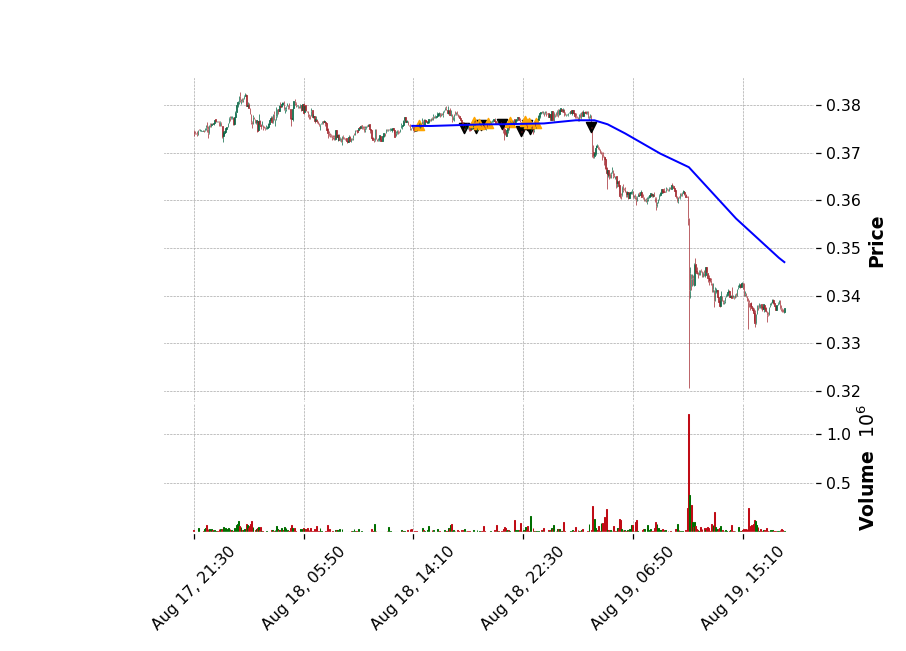

In [14]:
import mplfinance as mpf
import talib as ta
import matplotlib.pyplot as plt
# import numpy as np
import pandas as pd
%matplotlib notebook
buyorsell=pd.DataFrame()
df = pd.read_pickle("data_pairs_kucoin_future_5m.pkl").loc[0,'pair']
df['date'] = df['date'].astype(str) +' '+ df['time'].astype(str)
df['date']= pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M:%S')
df.set_index('date', inplace=True)
df.drop('time', axis=1,inplace=True)
# df.reset_index(drop=True, inplace=True)

WMA60 = ta.WMA(df['close'], timeperiod=200)
buyorsell['buy'] =  (df['close'] > WMA60) & (df['close'].shift(1) <= WMA60)
buyorsell['sell'] = (df['close'] < WMA60) & (df['close'].shift(1) >= WMA60)
buy = df['close'].copy()
sell= df['close'].copy()

for i in range(len(buyorsell['buy'])):
    if not buyorsell['buy'].iloc[i]:
#         print(i,buyorsell['buy'].iloc[i])
        buy.iloc[i] = float('nan')
print('')
for i in range(len(buyorsell['sell'])):
    if not buyorsell['sell'].iloc[i]:
#         print(i,buyorsell['sell'].iloc[i])
        sell.iloc[i] = float('nan')
apd = [mpf.make_addplot(WMA60,color='blue'),mpf.make_addplot(sell,type='scatter',markersize=40,marker='v',color='black'),
mpf.make_addplot(buy,type='scatter',markersize=40,marker='^',color='orange')]

mpf.plot(df,addplot=apd, type='candle',style='charles',volume=True)

In [2]:
!pip3 install mplfinance

  Using cached mplfinance-0.12.9b1-py3-none-any.whl (70 kB)
     ---------------------------------------- 7.2/7.2 MB 1.1 MB/s eta 0:00:00
     -------------------------------------- 55.3/55.3 kB 714.6 kB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ---------------------------------------- 3.3/3.3 MB 738.6 kB/s eta 0:00:00
     -------------------------------------- 947.1/947.1 kB 2.1 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
